In [2]:
%pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 19.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.stats import gaussian_kde
from netCDF4 import Dataset

In [5]:
from netCDF4 import Dataset

def nc_list(file1):
    """
    Lists all variables in a given NetCDF file, displaying their names, dimensions, and descriptions.
    
    Parameters:
    file1 (str): Path to the NetCDF file.

    Output:
    Prints a formatted table of variables with their dimensions and descriptions.
    """
    ncfile = Dataset(file1, 'r')

    print("{:<4} {:25} {:>10} {:>10}  {:30}".format("No", "Varname", "shape1", "shape2", "Description")) 
    print("-" * 100)

    nc = 1
    for varname in ncfile.variables.keys():
        var = ncfile.variables[varname]
        
        # Retrieve description from correct attribute
        description = getattr(var, "longname", "N/A")

        # Get variable dimensions
        dims = [len(ncfile.dimensions[dim]) for dim in var.dimensions]

        # Ensure at least 2 shape values
        shape1 = dims[0] if len(dims) > 0 else ""
        shape2 = dims[1] if len(dims) > 1 else ""

        print("{:<4} {:25} {:>10} {:>10}  {:30}".format(nc, varname, shape1, shape2, description))

        if nc % 10 == 0: 
            print("-" * 100)
        nc += 1

    ncfile.close()

# Example usage
file = "monAIREP.nc"
nc_list(file)


No   Varname                       shape1     shape2  Description                   
----------------------------------------------------------------------------------------------------
1    i_body                         37198             index of 1st entry in report body
2    l_body                         37198             number of entries in report body
3    n_level                        37198             number of levels in report    
4    data_category                  37198             BUFR4 data category           
5    sub_category                   37198             BUFR4 data sub-category       
6    center                         37198             station processing center     
7    sub_center                     37198             station processing sub-center 
8    obstype                        37198             observation type              
9    codetype                       37198             code type                     
10   ident                          37198   

In [6]:
file="synop.nc"
nc_list(file)

No   Varname                       shape1     shape2  Description                   
----------------------------------------------------------------------------------------------------
1    edition_number                 11993             N/A                           
2    section1                       11993         22  N/A                           
3    section2                       11993         18  N/A                           
4    section1_master_table_nr       11993             N/A                           
5    section1_subcentre             11993             N/A                           
6    section1_centre                11993             N/A                           
7    section1_update_sequence_nr      11993             N/A                           
8    section1_data_category         11993             N/A                           
9    section1_int_data_sub_category      11993             N/A                           
10   section1_local_data_sub_category     

In [7]:
from netCDF4 import Dataset
import numpy as np

def read_synop_data(filename):
    """
    Reads latitude (MLAH), longitude (MLOH), and temperature (MTDBT) from a NetCDF file.

    Parameters:
    filename (str): Path to the NetCDF file.

    Returns:
    tuple: (lats, lons, temps) - Arrays containing latitude, longitude, and temperature values.
    """
    # Open the NetCDF file
    ncfile = Dataset(filename, 'r')

    # Read latitude, longitude, and temperature variables
    try:
        lats = ncfile.variables["MLAH"][:]
        lons = ncfile.variables["MLOH"][:]
        temps = ncfile.variables["MTDBT"][:]  # Assuming MTDBT is temperature
        
        # Convert to numpy arrays
        lats = np.array(lats)
        lons = np.array(lons)
        temps = np.array(temps)

    except KeyError as e:
        print(f"Error: Variable {e} not found in file.")
        lats, lons, temps = None, None, None

    # Close the NetCDF file
    ncfile.close()

    return lats, lons, temps

# Example usage
filename = "synop.nc"
lats, lons, temps = read_synop_data(filename)

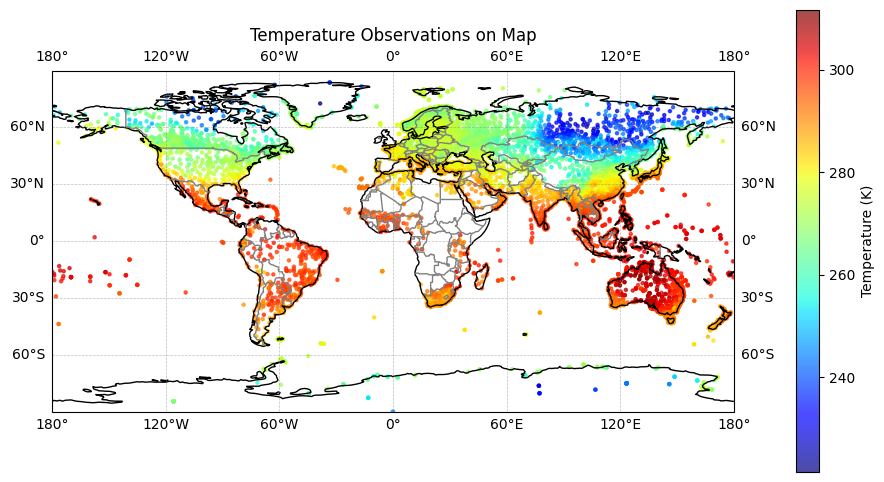

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_temperature_map(lats, lons, temps, filename="synop.png", threshold=1e+20):
    """Plots temperature observations on a map, removes large missing values, ensures proper colorbar spacing, and saves the figure."""

    # Filter out large missing values
    valid_mask = (temps < threshold) & np.isfinite(temps)
    lats, lons, temps = lats[valid_mask], lons[valid_mask], temps[valid_mask]

    # Create figure with proper aspect ratio
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Scatter plot with temperature data
    scatter = ax.scatter(lons, lats, c=temps, cmap='jet', s=5, alpha=0.7, transform=ccrs.PlateCarree())

    # Add map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, edgecolor='gray')
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    # Add colorbar with better spacing
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.04, pad=0.08)  
    cbar.set_label("Temperature (K)")

    # Set title
    plt.title("Temperature Observations on Map")

    # Save and show the plot
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# Example usage
plot_temperature_map(lats, lons, temps)


In [9]:
from netCDF4 import Dataset

def nc_list(file1):
    """
    Lists all variables in a given NetCDF file, displaying their names, dimensions, and descriptions.
    """
    ncfile = Dataset(file1, 'r')

    print("{:<4} {:40} {:>10} {:>10}  {:30}".format("No", "Varname", "shape1", "shape2", "Description"))
    print("-"*110)

    nc = 1
    for varname in ncfile.variables.keys():
        var = ncfile.variables[varname]
        description = var.long_name if hasattr(var, "long_name") else "N/A"
        dims = [len(ncfile.dimensions[dim]) for dim in var.dimensions]
        shape1 = dims[0] if len(dims) > 0 else ""
        shape2 = dims[1] if len(dims) > 1 else ""
        print("{:<4} {:40} {:>10} {:>10}  {:30}".format(nc, varname, shape1, shape2, description))  
        if nc % 10 == 0:
            print("-"*110)
        nc += 1
    ncfile.close()

file = "monAIREP.nc"
nc_list(file)

No   Varname                                      shape1     shape2  Description                   
--------------------------------------------------------------------------------------------------------------
1    i_body                                        37198             N/A                           
2    l_body                                        37198             N/A                           
3    n_level                                       37198             N/A                           
4    data_category                                 37198             N/A                           
5    sub_category                                  37198             N/A                           
6    center                                        37198             N/A                           
7    sub_center                                    37198             N/A                           
8    obstype                                       37198             N/A                 

In [10]:
from netCDF4 import Dataset
import numpy as np

def read_airep_data(filename, varno, extra_vars=None):
    """Reads latitude, longitude, selected observations, and additional variables from a NetCDF file."""
    if extra_vars is None:
        extra_vars = []

    ncfile = Dataset(filename, 'r')
    
    # Read header-level variables
    lat = ncfile.variables["lat"][:]  # Shape: (d_hdr,)
    lon = ncfile.variables["lon"][:]  # Shape: (d_hdr,)
    
    # Read body-level variables
    varno_all = ncfile.variables["varno"][:]  # Shape: (d_body,)
    obs_all = ncfile.variables["obs"][:]      # Shape: (d_body,)
    l_body = ncfile.variables["l_body"][:]    # Shape: (d_hdr,)

    # Expand lat/lon to match body-level observations
    ni = len(l_body)
    ie = np.repeat(range(0, ni), l_body)  # Map each body entry to its header index

    # Find matching variable numbers
    idx = np.where(varno_all == varno)[0]

    # Filter lat, lon, obs
    lat_filtered = lat[ie[idx]]
    lon_filtered = lon[ie[idx]]
    obs_filtered = obs_all[idx]

    # Read extra variables if requested
    extra_data = {}
    for var in extra_vars:
        if var in ncfile.variables:
            var_data = ncfile.variables[var][:]
            extra_data[var] = var_data[idx] if var_data.shape[0] == len(varno_all) else var_data[ie[idx]]
        else:
            print(f"Warning: Variable '{var}' not found in NetCDF file.")

    ncfile.close()
    
    return lat_filtered, lon_filtered, obs_filtered, extra_data

# Example usage
varno = 2  # Example: upper air temperature
extra_vars = ["level", "level_sig"]  # Example: read additional height-related data
lats, lons, obs, extra_data = read_airep_data("monAIREP.nc", varno, extra_vars)

# Access extra data
heights = extra_data.get("level", None)  # Use "level" or "level_sig" for height

# Print some values to verify
print(len(lats), "Latitudes:", lats[:5])
print(len(lons), "Longitudes:", lons[:5])
print(len(obs), "Observations:", obs[:5])
if heights is not None:
    print(len(heights), "Heights:", heights[:5])


37198 Latitudes: [36.958 40.87  40.96  41.04  41.11 ]
37198 Longitudes: [-89.69 -93.18 -93.24 -93.28 -93.32]
37198 Observations: [222.72336 250.22017 257.22015 257.92017 261.62015]
37198 Heights: [20660.502 58864.67  67838.71  70546.51  77289.73 ]


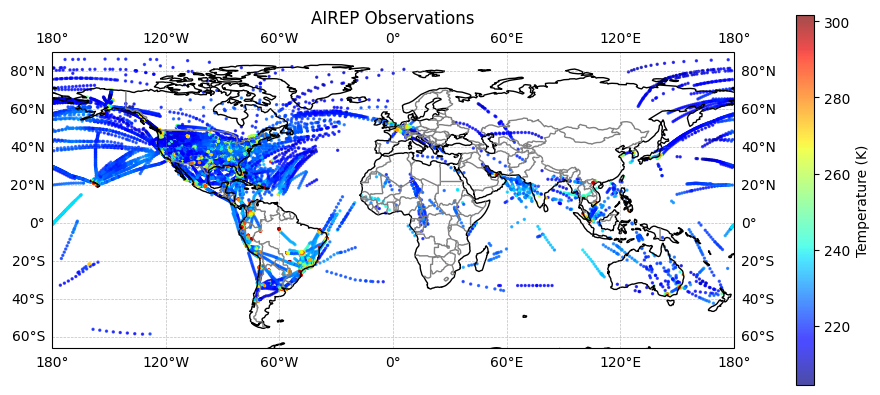

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def filter_airep_data(lats, lons, obs, threshold=1e+20):
    """Filters AIREP observations by removing missing values and out-of-range temperatures."""

    # Step 1: Remove missing values
    valid_mask = (obs < threshold) & np.isfinite(obs)
    lats, lons, obs = lats[valid_mask], lons[valid_mask], obs[valid_mask]

    # Step 2: Keep only temperatures between -30°C and 40°C (243.15K to 313.15K)
    temp_min, temp_max = 180, 320
    physical_mask = (obs >= temp_min) & (obs <= temp_max)

    return lats[physical_mask], lons[physical_mask], obs[physical_mask]

def plot_airep_map(lats, lons, obs, filename="airep.png"):
    """Plots AIREP observations on a map after filtering out-of-range temperatures."""

    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    scatter = ax.scatter(lons, lats, c=obs, cmap='jet', s=2, alpha=0.7, transform=ccrs.PlateCarree())

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, edgecolor='gray')
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    # ✅ Ensure the colorbar does not exceed figure height
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.04, pad=0.08, shrink=0.8)
    cbar.set_label("Temperature (K)")

    plt.title("AIREP Observations")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# Example usage
lats_filtered, lons_filtered, obs_filtered = filter_airep_data(lats, lons, obs)
plot_airep_map(lats_filtered, lons_filtered, obs_filtered)


In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.stats import gaussian_kde
from netCDF4 import Dataset

def plot_global_density(lats, lons,
                        filename="airep_global_density.png"):
    """Generates a density plot of AIREP observations on a world map 
    with an optimized colormap."""
    fig, ax = plt.subplots(figsize=(10, 6),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Compute 2D histogram
    hist, xedges, yedges = np.histogram2d(lons, lats,
                                          bins=100, density=True)
    
    # Use a perceptually uniform colormap (e.g., 'inferno')
    pcm = ax.pcolormesh(xedges, yedges, hist.T, cmap='inferno',
                        norm=plt.matplotlib.colors.LogNorm(
                            vmin=hist[hist > 0].min(),
                            vmax=hist.max()),
                        transform=ccrs.PlateCarree())
    
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, edgecolor='gray')
    ax.gridlines(draw_labels=True, linewidth=0.5,
                 color='gray', alpha=0.5, linestyle='--')
    
    # Adjust padding to ensure axis does not crowd the figure
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    
    # Ensure colorbar does not exceed figure size
    cbar = fig.colorbar(pcm, ax=ax, orientation='vertical',
                        fraction=0.04, pad=0.04, shrink=0.8)
    cbar.set_label("Observation Density")
    
    plt.title("AIREP Observation Density (Global)")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

def plot_height_histogram(lons, heights,
                           filename="airep_height_density.png"):
    """Generates a histogram of longitude vs. height, converting pressure
    to altitude with 1000 hPa at the bottom and 200 hPa at the top."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Convert pressure Pa to hPa 
    heights = heights / 100 
    
    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(lons, heights,
                                          bins=(100, 50))
    
    # Use the same optimized colormap as in global density plot
    pcm = ax.pcolormesh(xedges, yedges, hist.T, cmap='inferno',
                        norm=plt.matplotlib.colors.LogNorm(
                            vmin=hist[hist > 0].min(),
                            vmax=hist.max()))
    
    cbar = fig.colorbar(pcm, ax=ax, orientation='vertical',
                        fraction=0.04, pad=0.08)
    cbar.set_label("Density")
    
    plt.xlabel("Longitude")
    plt.ylabel("Pressure (hPa)")
    plt.title("AIREP Observation Density: Longitude vs. Pressure")
    plt.ylim(1000, 200)  # Invert y-axis so 1000 hPa is at bottom
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# Example usage
# plot_global_density(lats, lons)
# plot_height_histogram(lons, heights)


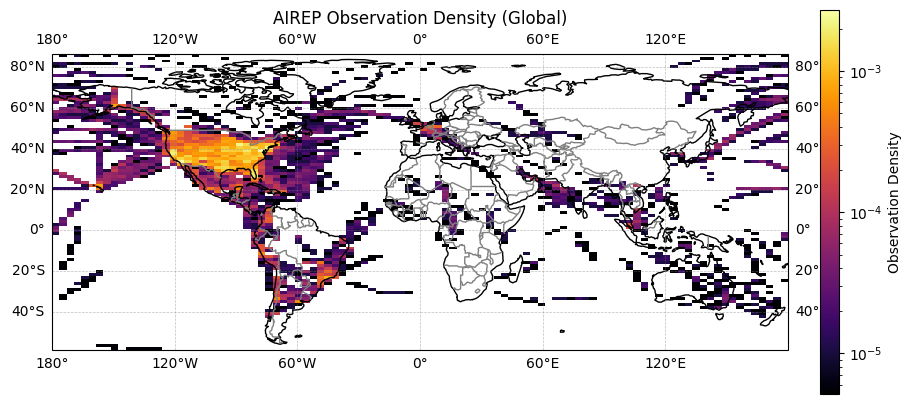

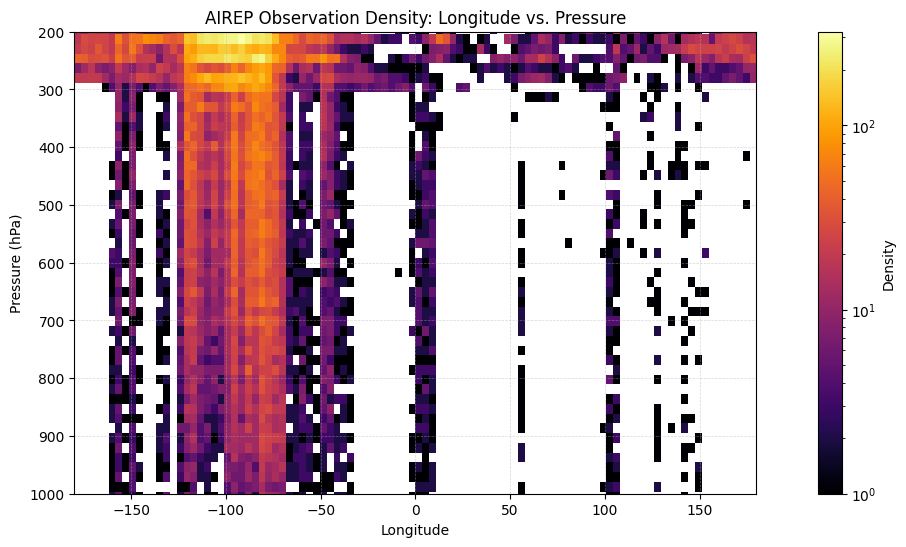

In [13]:
# Example usage
plot_global_density(lats, lons)
plot_height_histogram(lons, heights)
